This notebook collects the scripts used in the analysis of the AAA trinucleotide trajectories reported in

Pinamonti, G., Zhao, J., Condon, D.E., Paul, F., Noe, F., Turner, D.H., Bussi, G., (2016) "Studying the\
 kinetic properties of RNA oligonucleotides with Markov state models", submitted

Please cite us if using this data or any of these analysis tools.


Input MD data can be downloaded from
https://drive.google.com/open?id=0B5ljL0_IChrSSlFqUlZYelVuLWc

In [1]:
# Useful stuff
import sys
import cPickle as pickle
import time
import numpy as np

# PyEmma
import pyemma
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl

# plot
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline

# my scripts
import my_tools as my
import readwrite as rw
import gvec_func as gv
import pvec_func as pv
import dihedrals_func as dih

# 1 - Discretization

I start by defining the input files names and the input coordinates (G-vectors [Bottaro et al. (2014) NAR] and dihedrals of backbone, sugar ring and glycosidic bond)

In [2]:
# input files definitions
directo='MD-data/trino/'
trajfiles=[directo+'traj-strip.xtc']
for idir in range(1,5):
    for irun in range(4):
        trajfiles.append(directo+'traj-strip_'+str(idir)+'_'+str(irun)+'.xtc')
topfile=directo+'setup.gro'

In [3]:
feat_dGP=coor.featurizer(topfile)
nres=3

feat_dGP.add_custom_func(gv.get_gvecs,4*nres*nres)
top=feat_dGP.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dGP.add_dihedrals(ll,cossin=True,periodic=False)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dGP.add_dihedrals(ll,cossin=True,periodic=False)
lista_chis=dih.get_chi_ndx(top)
feat_dGP.add_dihedrals(lista_chis,cossin=True,periodic=False)

inp_dGP = coor.source(trajfiles, feat_dGP)

Obtaining file info: 100% (17/17) [################################] eta 00:01 /

In [4]:
# Files for output structures
featXout=coor.featurizer(topfile)
featXout.add_all()
inpXout = coor.source(trajfiles, featXout)

Obtaining file info: 100% (17/17) [################################] eta 00:01 -

In [5]:
print 'N. trajectories =',inp_dGP.ntraj
print 'N. frames =',inp_dGP.n_frames_total()
print 'Total length =',inp_dGP.n_frames_total()/10000., 'microseconds'

N. trajectories = 17
N. frames = 570677
Total length = 57.0677 microseconds


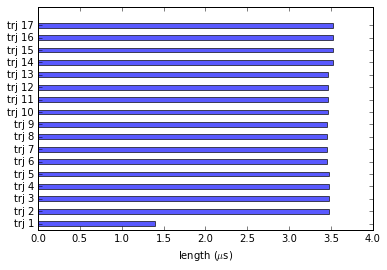

In [6]:
ppp=plt.barh(np.arange(0.3,inp_dGP.ntraj),\
             inp_dGP.trajectory_lengths()/10000.,height=0.4,alpha=0.65)
plt.yticks(np.arange(0.5,inp_dGP.ntraj),['trj %d'%i for i in range(1,inp_dGP.ntraj+1)])
plt.xlabel(r'length ($\mu$s)')

## 1.1 - TICA analysis:

dimensionality reduction with time-lagged independent component analysis (TICA). Using a lagtime of $5$ ns.

In [7]:
%time traj=coor.load(trajfiles,feat_dGP,chunk_size=1000)

getting output of FeatureReader: 100% (579/579) [##################] eta 00:01 -CPU times: user 7min 24s, sys: 636 ms, total: 7min 25s
Wall time: 7min 25s


In [8]:
tica_obj=coor.tica(traj,50)
tica_traj=tica_obj.get_output()
tica_dim,cumvar=my.get_tica_cumvar(tica_obj)
print 'dimension=%d' %tica_dim
#use this if you'd like to store the computed tica on disk
#rw.write_tica_eval('trino_lt50',tica_obj)
#rw.write_tica_evec('trino_lt50',tica_obj)
#rw.write_tica_trajs('trino_lt50',tica_traj)

getting output of TICA: 100% (119/119) [###########################] eta 00:01 |dimension=17


In [9]:
### use this to read previously stored ticas
#tica_eval=rw.read_tica_eval('trino_lt50')
#tica_evec=rw.read_tica_evec('trino_lt50')
#tica_traj=rw.read_tica_trajs('trino_lt50',inp_dGP.ntraj)
#tica_dim=tica_traj[0].shape[1]
#print tica_dim

##  1.2 - Clustering:

Discretizing the TICA space using k-means clustering algorithm. Using $k=100$ cluster centers

In [11]:
# Clustering with k-means
%time cl = coor.cluster_kmeans(data=[X[:,0:tica_dim] for X in tica_traj],\
                               k=100,stride=1,max_iter=50,fixed_seed=True)
dtrajs = cl.assign(stride=1)
cl_centers=cl.clustercenters
### this to store clustering on disk
#rw.write_cl_dtrajs('trino_lt50_k100',dtrajs)
#rw.write_cl_centers('trino_lt50_k100',cl)
#rw.write_cl_indexes('trino_lt50_k100',cl)
### and this to read it
#cl_centers=rw.read_cl_centers('trino_lt50_k100')
#dtrajs=rw.read_cl_dtrajs('trino_lt50_k100',inp_dGP.ntraj)

kmeans iterations:  28% (14/50) [#########                         ] eta 03:01 -09-12-16 13:19:10 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Cluster centers converged after 15 steps.
kmeans iterations: 100% (50/50) [##################################] eta 02:56 /CPU times: user 1min 38s, sys: 184 ms, total: 1min 38s
Wall time: 1min 35s
getting output of KmeansClustering: 100% (119/119) [###############] eta 00:01 |

## 1.3 - Implied timescales:

From the convergence of the implied timescales we can assess the Markovianity of the MSM

In [12]:
### Implied timescales
its=msm.its(dtrajs,lags=[1,5,10,20,30,40,50,60,80,100,120,150,200,250,300,400],nits=15)

estimating MaximumLikelihoodMSM: 100% (16/16) [####################] eta 00:01 /

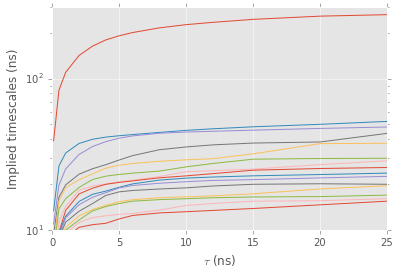

In [13]:
with plt.style.context(('ggplot')):
    plt.plot(its.lags/10.,its.timescales/10.,lw=1.)
    plt.ylim(10,300)
    plt.xlim(0,25)
    plt.yscale('log')
    plt.ylabel('Implied timescales (ns)')
    plt.xlabel(r'$\tau$ (ns)')

The ITS are converging slowly after 5 ns

# 2 - Markov state model construction and analysis

The MSM is build with lagtime $\tau = 5$ ns.

In [110]:
M=msm.estimate_markov_model(dtrajs,50)

In [15]:
M.active_state_fraction

1.0

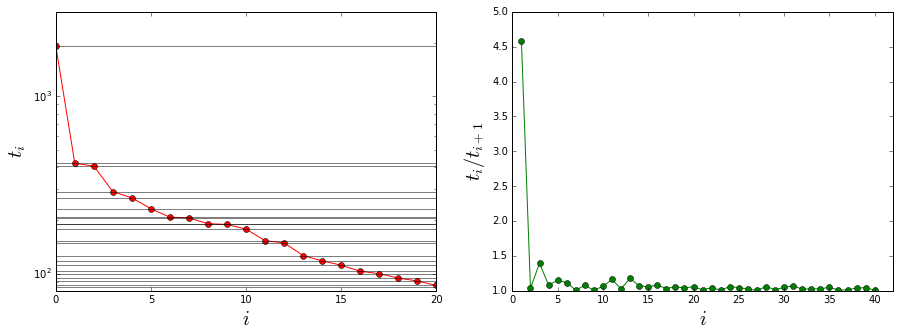

In [16]:
plt.figure(figsize=(15,5))
plt.subplot2grid((1,2),(0,0))
### Eigenvalues plot
plt.plot(M.timescales()[:22],marker='o', color='red')
plt.plot([0,21],[80,80])
for ts in M.timescales()[:22]:
    plt.plot([0,21],[ts,ts],c='black',lw=0.5)
plt.yscale('log')
plt.ylim(80,3000)
plt.xlim(0,20)
plt.ylabel('$t_i$',fontsize=20)
plt.xlabel('$i$',fontsize=20)
plt.subplot2grid((1,2),(0,1))
plt.plot(range(1,41),M.timescales()[0:40]/M.timescales()[1:41],marker='o',color='green')
plt.xlabel('$i$',fontsize=20)
plt.xlim(0,42)
plt.ylabel('$t_i / t_{i+1}$',fontsize=20)

In [17]:
BM=msm.bayesian_markov_model(dtrajs,50)
bm_timescales_std=BM.sample_std('timescales')

Sampling MSMs: 100% (100/100) [####################################] eta 00:01 -

In [18]:
print 'MSM timescales:'
for i in range(7):
    print('%3.f +/- %2.f ns' % (M.timescales()[i]/10,bm_timescales_std[i]/10) )

MSM timescales:
192 +/-  5 ns
 42 +/-  1 ns
 40 +/-  1 ns
 29 +/-  1 ns
 27 +/-  1 ns
 23 +/-  1 ns
 21 +/-  1 ns


The model identify a very slow process ($t\simeq200$ ns). The fastest processes are dominated by two timescales around $40$ ns

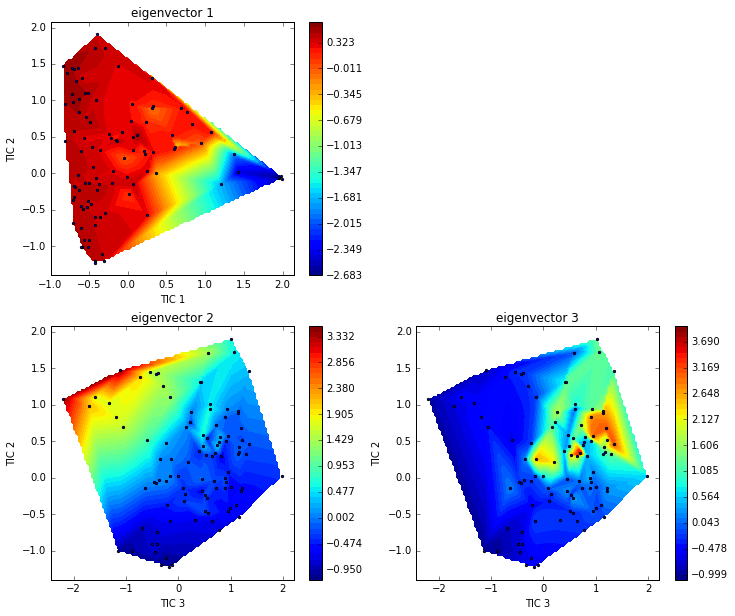

In [19]:
cl_centers=cl.clustercenters
plt.figure(figsize=(12,10))
plt.subplot2grid((2,2),(0,0))
icomp=1
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,0], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 2');plt.xlabel('TIC 1')
plt.subplot2grid((2,2),(1,0))
icomp=2
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 2');plt.xlabel('TIC 3')
plt.subplot2grid((2,2),(1,1))
icomp=3
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 2');plt.xlabel('TIC 3')

## 2.1 - Coarse graining the MSM with an hidden Markov model

In [20]:
colors=np.array(['blue','red','green','gold'])

In [21]:
HMM4=M.coarse_grain(4)
nstates=4

09-12-16 13:20:43 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[3] WARNING  Requested coarse-grained model with 4 metastable states at lag=50.The ratio of relaxation timescales between 4 and 5 states is only 1.395185396 while we recommend at least 1.5.  It is possible that the resulting HMM is inaccurate. Handle with caution.


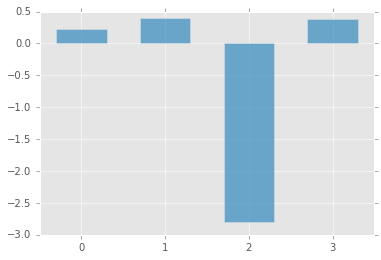

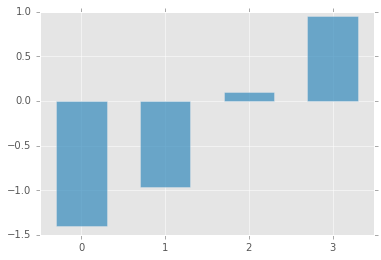

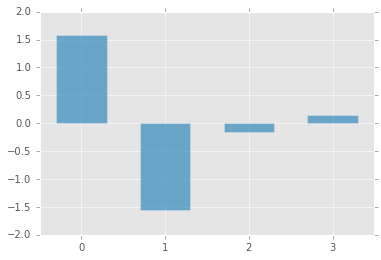

In [22]:
for icomp in range(1,nstates):
    plt.figure()
    with plt.style.context(('ggplot')):
        plt.bar(np.array(range(nstates))-0.3,\
                HMM4.eigenvectors_right()[:,icomp],width=0.6,alpha=0.7)
        plt.xlim(-0.5,3.5)
        plt.xticks(range(0,nstates))

In [23]:
Ytot=tica_traj[0]
for i in range(1,len(tica_traj)):
    Ytot=np.concatenate((Ytot,tica_traj[i]))
ix=0
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F01 = -np.log(z)
extent01 = [x[0], x[-1], y[0], y[-1]]
ix=2
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F21 = -np.log(z)
del Ytot
extent21 = [x[0], x[-1], y[0], y[-1]]

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


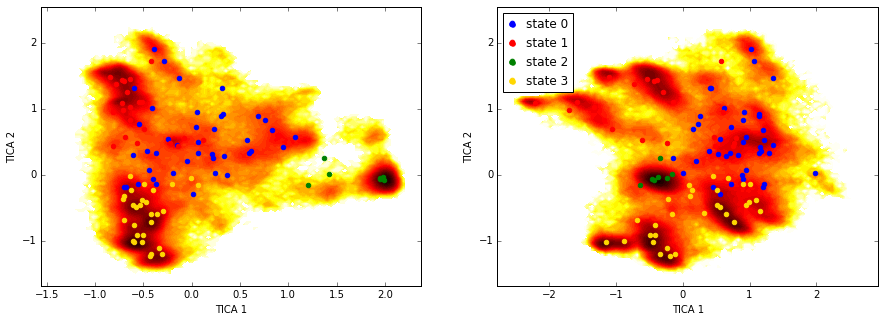

In [24]:
### HMM metastable states, projected on the first 2 TICs, with the density plot from the trajectories
# NB: trajectories NOT completely at equlibrium, so density plot is only for visualization 
#     does not correspond to the true distribution

fig = plt.figure(figsize=(15,5))
plt.subplot2grid((1,2),(0,0))
ix=0
iy=1
pcca_sets = HMM4.metastable_sets
plt.contourf(F01.T, 50, cmap=plt.cm.hot, extent=extent01)
for ipcca in range(len(pcca_sets)):
    plt.scatter(cl_centers[pcca_sets[ipcca],ix], cl_centers[pcca_sets[ipcca],iy]\
                , color=colors[ipcca],label='state '+str(ipcca))
plt.ylabel('TICA 2')
plt.xlabel('TICA 1')
plt.subplot2grid((1,2),(0,1))
ix=2
iy=1
pcca_sets = HMM4.metastable_sets
plt.contourf(F21.T, 50, cmap=plt.cm.hot, extent=extent21)
for ipcca in range(len(pcca_sets)):
    plt.scatter(cl_centers[pcca_sets[ipcca],ix], cl_centers[pcca_sets[ipcca],iy]\
                , color=colors[ipcca],label='state '+str(ipcca))
plt.ylabel('TICA 2')
plt.xlabel('TICA 1')
plt.legend(loc=2,numpoints=1,handlelength=0.7)

In [25]:
BHMM=msm.bayesian_hidden_markov_model(dtrajs,4,50)

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


Sampling HMSMs: 100% (100/100) [###################################] eta 00:01 \

In [26]:
bhmm_statdist_std=BHMM.sample_std('stationary_distribution')

In [27]:
i=0
print '#state | population'
for x in HMM4.stationary_distribution:
    print '  %d        %2.f +/- %1.f%%'% (i,x*100,np.sqrt(3)*bhmm_statdist_std[i]*100)
    i+=1

#state | population
  0        18 +/- 3%
  1        22 +/- 2%
  2        11 +/- 6%
  3        48 +/- 5%


In [28]:
bhmm_timescales_std=BHMM.sample_std('timescales')

In [29]:
print ' *** Timescales (ns)*** '
print 'idx |     MSM    |     HMM'
for i in range(3):
    print ' %d    %3.f +/- %2.f    %3.f +/- %2.f'\
    % (i,M.timescales()[i]/10,bm_timescales_std[i]/10,HMM4.timescales()[i]/10,bhmm_timescales_std[i]/10)

 *** Timescales (ns)*** 
idx |     MSM    |     HMM
 0    192 +/-  5    295 +/- 53
 1     42 +/-  1     41 +/-  2
 2     40 +/-  1     39 +/-  2


In [30]:
states_pos=np.array([\
            np.sum(cl_centers[:,:2]*HMM4.metastable_distributions[istate][:,np.newaxis],axis=0)\
            for istate in range(4)])

In [31]:
from scipy.linalg import logm
hmm_rate_matrix=logm(HMM4.transition_matrix)

In [32]:
HMM4.transition_matrix

array([[  9.04395141e-01,   3.01848100e-02,   6.27002210e-03,
          5.91500268e-02],
       [  2.48071687e-02,   9.11253071e-01,   3.05708036e-04,
          6.36340522e-02],
       [  1.01498922e-02,   6.02158002e-04,   9.84724584e-01,
          4.52336576e-03],
       [  2.23356761e-02,   2.92378198e-02,   1.05514830e-03,
          9.47371356e-01]])

In [33]:
hmm_rate_matrix2=hmm_rate_matrix/HMM4.lagtime*10*1e3
hmm_rate_matrix2[np.abs(hmm_rate_matrix2)<1e-1]=0.0

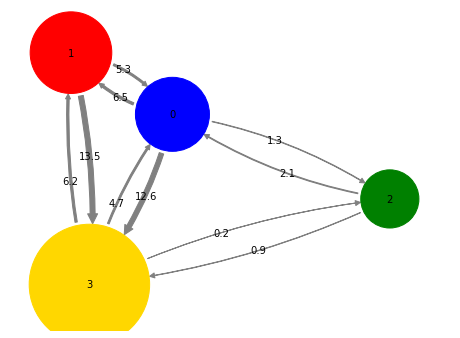

In [34]:
fff,ppp=mpl.plot_network(hmm_rate_matrix2,pos=states_pos,state_colors=colors,\
                     state_sizes=HMM4.stationary_distribution,arrow_label_format='%1.1f',\
                        max_width=8,state_scale=3)

# 3 -HMM's metastable states analysis

In [111]:
hmm_dist = HMM4.metastable_distributions
hmm_samples = M.sample_by_distributions(hmm_dist, 1000)
outfiles = ['trino_hmm'+str(i)+'_'+str(nstates)+'ms.xtc' for i in range(0,nstates)]
coor.save_trajs(inpXout, hmm_samples, outfiles=outfiles)

['trino_hmm0_4ms.xtc',
 'trino_hmm1_4ms.xtc',
 'trino_hmm2_4ms.xtc',
 'trino_hmm3_4ms.xtc']

## 3.1 Dihedrals

In [112]:
feat_dih=coor.featurizer(topfile)
top=feat_dih.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_chis=dih.get_chi_ndx(top)
feat_dih.add_dihedrals(lista_chis,cossin=False)

In [113]:
### cmomputing observables
dih_meta_states=np.array(coor.load(outfiles,feat_dih))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 -

In [114]:
stat_dist = M.stationary_distribution
stat_samples = M.sample_by_distributions([stat_dist], 1000)
trajfiles_statdist=['trino_statdist.xtc']
coor.save_trajs(inpXout, stat_samples, outfiles=trajfiles_statdist)
### cmomputing observables
dih_statdist=np.array(coor.load(trajfiles_statdist,feat_dih))

In [115]:
dih_names=[]
for lll,name in zip(lista_dihedrals,[r'$\alpha',r'$\beta',r'$\gamma',r'$\delta',r'$\epsilon',r'$\zeta']):
    for i in range(len(lll)):
        if name==r'$\alpha' or name==r'$\beta':
            dih_names.append(name+'_'+str(i+2)+'$')
        else:
            dih_names.append(name+'_'+str(i+1)+'$')
for lll,name in zip(lista_pucker,[r'$\nu^0',r'$\nu^1',r'$\nu^2',r'$\nu^3',r'$\nu^4']):
    for i in range(len(lll)):
        dih_names.append(name+'_'+str(i+1)+'$')
lll=lista_chis
name=r'$\chi'
for i in range(len(lll)):
    dih_names.append(name+'_'+str(i+1)+'$')
print len(dih_names), 'dihedrals'

32 dihedrals


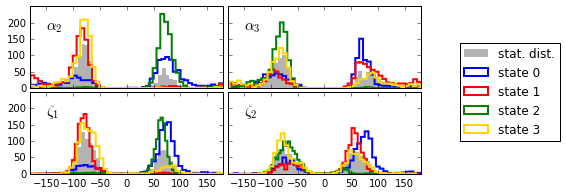

In [116]:
iplot=0
fig, axes = plt.subplots(2,2, \
        figsize=(7,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
for i_dih in[0,1]:
    ax=axes[0,iplot]
    ax.text(-150,180,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,\
                 histtype='step',lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    ax.set_xlim(-180,180)
    ax.set_ylim(0,250)
    ax.yaxis.set_ticks(range(0,201,50))
    iplot+=1
    
iplot=0
for i_dih in[12,13]:
    ax=axes[1,iplot]
    ax.text(-150,180,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                 label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                 lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    iplot+=1
    ax.set_xlim(-180,180)
    ax.set_ylim(0,250)
    ax.yaxis.set_ticks(range(0,201,50))
plt.legend(loc=(1.2,0.4))

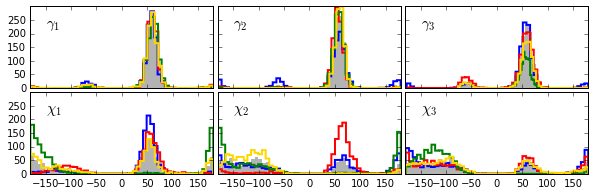

In [117]:
iplot=0
fig, axes = plt.subplots(2,3, \
        figsize=(10,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
for i_dih in[4,5,6]:
    ax=axes[0,iplot]
    ax.text(-150,250*0.9,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,\
                 histtype='step',lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    ax.set_xlim(-180,180)
    ax.set_ylim(0,300)
    ax.yaxis.set_ticks(range(0,251,50))
    iplot+=1
    
iplot=0
for i_dih in[29,30,31]:
    ax=axes[1,iplot]
    ax.text(-150,250*0.9,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                 label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                 lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    iplot+=1
    ax.set_xlim(-180,180)
    ax.set_ylim(0,300)
    ax.yaxis.set_ticks(range(0,251,50))

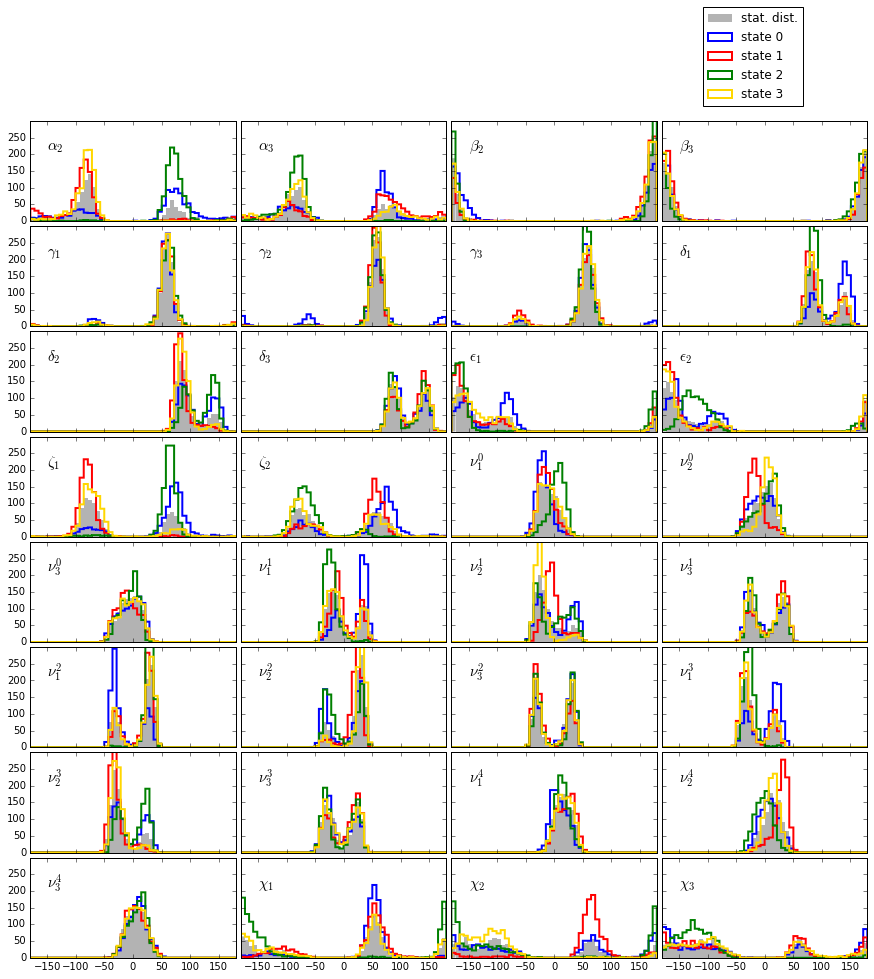

In [118]:
fig, axes = plt.subplots(8,4, \
        figsize=(15,15),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
for i_dih in range(32):
    ax=axes[i_dih/4,i_dih%4]
    ax.text(-150,210,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,range=(-180,180),normed=False,\
                label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,\
                 histtype='step',lw=2,bins=50,range=(-180,180),normed=False,\
                 label='state '+str(istate),color=colors[istate])
    ax.set_xlim(-180,180)
    ax.set_ylim(0,300)
    ax.yaxis.set_ticks(range(0,251,50))
    
plt.legend(loc=(0.2,8.5))

## 3.2 - Hydrogen bonds

In [119]:
feat_hb=coor.featurizer(topfile)
idx_neg=feat_hb.select('name N7 or name OP1 or name OP2 or name N3 or name N1 or \
                        name "O4\'" or name "O3\'" or name "O5\'" or name "O2\'"')
idx_pos=feat_hb.select('name H61 or name H62 or name "H5T" or name "HO5\'" or name \
"HO2\'" or name "HO\'2" or name "HO3\'" or name "H3T"')
print idx_neg
print idx_pos
feat_hb.add_contacts(indices=idx_pos,indices2=idx_neg,periodic=False,threshold=0.21)

feat_hb.dimension()

[ 0  7 13 19 22 28 30 32 33 34 40 46 52 55 61 63 65 66 67 73 79 85 88 94 96]
[ 1 17 18 29 50 51 62 83 84 95 97]
09-12-16 16:35:47 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[25] WARNING  The 1D arrays input for add_contacts() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


275

In [120]:
print 'N. of features:',feat_hb.dimension()
### cmomputing observables
hb_meta_states=np.array(coor.load(outfiles,feat_hb))
### cmomputing observables
hb_statdist=np.array(coor.load(trajfiles_statdist,feat_hb))

N. of features: 275
getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 -

In [124]:
hb_perc=np.concatenate((np.sum(hb_statdist,axis=0)[np.newaxis,:]/10.,\
                        np.sum(hb_meta_states,axis=1)/10.),axis=0)
print hb_perc.shape
hb_err=np.concatenate((np.sqrt(np.sum(hb_statdist,axis=0))[np.newaxis,:]/10.,\
                        np.sqrt(np.sum(hb_meta_states,axis=1))/10.),axis=0)
print hb_err.shape

(5, 275)
(5, 275)


In [125]:
hb_names=np.array([feat_hb.describe()[i_dih][9:] for i_dih in range(275)])

In [126]:
idx_hb=np.where(np.sum(hb_perc,axis=0)>hb_perc.shape[0]*1.)[0]
idx_hb=idx_hb[np.where(np.sum(hb_perc[:,idx_hb],axis=0)<hb_perc.shape[0]*100)[0]]

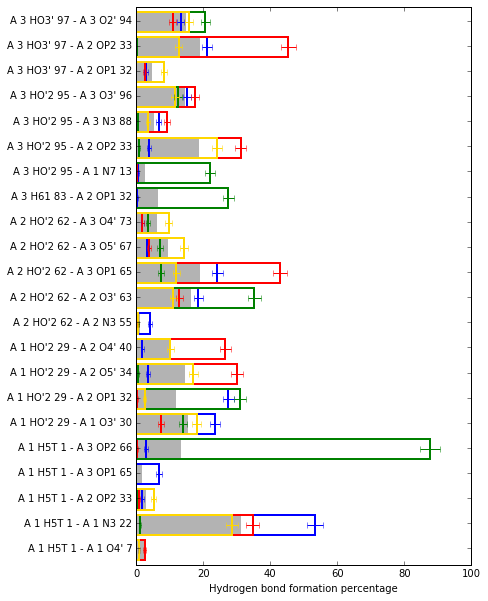

In [127]:
plt.figure(figsize=(6,10))
plt.barh(range(len(idx_hb)),hb_perc[0,idx_hb],color='0.7',edgecolor='0.7')
for istate in range(nstates):
    plt.barh(range(len(idx_hb)),hb_perc[istate+1,idx_hb],xerr=hb_err[istate+1,idx_hb],\
             ecolor=colors[istate],color='',edgecolor=colors[istate],lw=2)
plt.ylim(-0.2,len(idx_hb))
plt.xlim(0,100)
tcks=plt.yticks(np.arange(0.45,float(len(idx_hb)),1.),hb_names[idx_hb])
plt.xlabel('Hydrogen bond formation percentage')

## 3.3 - Ions

In [128]:
feat_ib=coor.featurizer(topfile)
idx_Na=feat_ib.select('name NA')
idx_Cl=feat_ib.select('name CL')
idx_neg=feat_ib.select('name N7 or name OP1 or name OP2 or name N3 or name N1 or \
                        name "O4\'" or name "O3\'" or name "O5\'" or name "O2\'"')
idx_pos=feat_ib.select('name H61 or name H62 or name H5T or name "2HO\'" or name "HO\'2" or name "HO3\'"')
print idx_Na,idx_Cl
print idx_neg
print idx_pos

for atom_ndx in idx_neg:
    feat_ib.add_group_mindist([[atom_ndx],idx_Na],threshold=0.28)
for atom_ndx in idx_pos:
    feat_ib.add_group_mindist([[atom_ndx],idx_Cl],threshold=0.35)
feat_ib.describe()

[ 98  99 100 101 102 103] [104 105 106 107]
[ 0  7 13 19 22 28 30 32 33 34 40 46 52 55 61 63 65 66 67 73 79 85 88 94 96]
[ 1 17 18 29 50 51 62 83 84 95 97]


["GROUP_MINDIST 0--1: [A 1 O5' 0...A 1 O5' 0]--[NA 2301 NA 98...NA 2306 NA 103]",
 "GROUP_MINDIST 0--1: [A 1 O4' 7...A 1 O4' 7]--[NA 2301 NA 98...NA 2306 NA 103]",
 'GROUP_MINDIST 0--1: [A 1 N7 13...A 1 N7 13]--[NA 2301 NA 98...NA 2306 NA 103]',
 'GROUP_MINDIST 0--1: [A 1 N1 19...A 1 N1 19]--[NA 2301 NA 98...NA 2306 NA 103]',
 'GROUP_MINDIST 0--1: [A 1 N3 22...A 1 N3 22]--[NA 2301 NA 98...NA 2306 NA 103]',
 "GROUP_MINDIST 0--1: [A 1 O2' 28...A 1 O2' 28]--[NA 2301 NA 98...NA 2306 NA 103]",
 "GROUP_MINDIST 0--1: [A 1 O3' 30...A 1 O3' 30]--[NA 2301 NA 98...NA 2306 NA 103]",
 'GROUP_MINDIST 0--1: [A 2 OP1 32...A 2 OP1 32]--[NA 2301 NA 98...NA 2306 NA 103]',
 'GROUP_MINDIST 0--1: [A 2 OP2 33...A 2 OP2 33]--[NA 2301 NA 98...NA 2306 NA 103]',
 "GROUP_MINDIST 0--1: [A 2 O5' 34...A 2 O5' 34]--[NA 2301 NA 98...NA 2306 NA 103]",
 "GROUP_MINDIST 0--1: [A 2 O4' 40...A 2 O4' 40]--[NA 2301 NA 98...NA 2306 NA 103]",
 'GROUP_MINDIST 0--1: [A 2 N7 46...A 2 N7 46]--[NA 2301 NA 98...NA 2306 NA 103]',
 'GR

In [129]:
### computing observables
ib_meta_states=np.array(coor.load(outfiles,feat_ib))
### cmomputing observables
ib_statdist=np.array(coor.load(trajfiles_statdist,feat_ib))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 -

In [130]:
for i_dih in range(feat_ib.dimension()):
    print '%s \t %.2f +- %.2f' % \
           (feat_ib.describe()[i_dih][21:28]+' -- '+feat_ib.describe()[i_dih].split()[-2],\
            np.sum(ib_statdist,axis=0)[i_dih]/10., np.sqrt(np.sum(ib_statdist,axis=0)[i_dih])/10)

A 1 O5' -- NA 	 0.80 +- 0.28
A 1 O4' -- NA 	 0.10 +- 0.10
A 1 N7  -- NA 	 1.10 +- 0.33
A 1 N1  -- NA 	 0.70 +- 0.26
A 1 N3  -- NA 	 0.20 +- 0.14
A 1 O2' -- NA 	 0.50 +- 0.22
A 1 O3' -- NA 	 0.20 +- 0.14
A 2 OP1 -- NA 	 2.60 +- 0.51
A 2 OP2 -- NA 	 2.40 +- 0.49
A 2 O5' -- NA 	 0.20 +- 0.14
A 2 O4' -- NA 	 0.30 +- 0.17
A 2 N7  -- NA 	 1.50 +- 0.39
A 2 N1  -- NA 	 0.10 +- 0.10
A 2 N3  -- NA 	 0.40 +- 0.20
A 2 O2' -- NA 	 0.70 +- 0.26
A 2 O3' -- NA 	 0.30 +- 0.17
A 3 OP1 -- NA 	 3.00 +- 0.55
A 3 OP2 -- NA 	 1.70 +- 0.41
A 3 O5' -- NA 	 0.30 +- 0.17
A 3 O4' -- NA 	 0.40 +- 0.20
A 3 N7  -- NA 	 1.60 +- 0.40
A 3 N1  -- NA 	 0.70 +- 0.26
A 3 N3  -- NA 	 0.60 +- 0.24
A 3 O2' -- NA 	 0.80 +- 0.28
A 3 O3' -- NA 	 1.30 +- 0.36
A 1 H5T -- CL 	 0.30 +- 0.17
A 1 H61 -- CL 	 0.20 +- 0.14
A 1 H62 -- CL 	 0.00 +- 0.00
A 1 HO' -- CL 	 0.00 +- 0.00
A 2 H61 -- CL 	 0.00 +- 0.00
A 2 H62 -- CL 	 0.00 +- 0.00
A 2 HO' -- CL 	 0.00 +- 0.00
A 3 H61 -- CL 	 0.00 +- 0.00
A 3 H62 -- CL 	 0.00 +- 0.00
A 3 HO' -- CL 

In [131]:
ib_perc=np.concatenate((np.sum(ib_statdist,axis=0)[np.newaxis,:]/10.,\
                        np.sum(ib_meta_states,axis=1)/10.),axis=0)
print ib_perc.shape
ib_err=np.concatenate((np.sqrt(np.sum(ib_statdist,axis=0))[np.newaxis,:]/10.,\
                        np.sqrt(np.sum(ib_meta_states,axis=1))/10.),axis=0)

(5, 36)


In [132]:
ib_names=[feat_ib.describe()[i_dih][21:28]+' -- '+feat_ib.describe()[i_dih].split()[-2] for i_dih in range(36)]

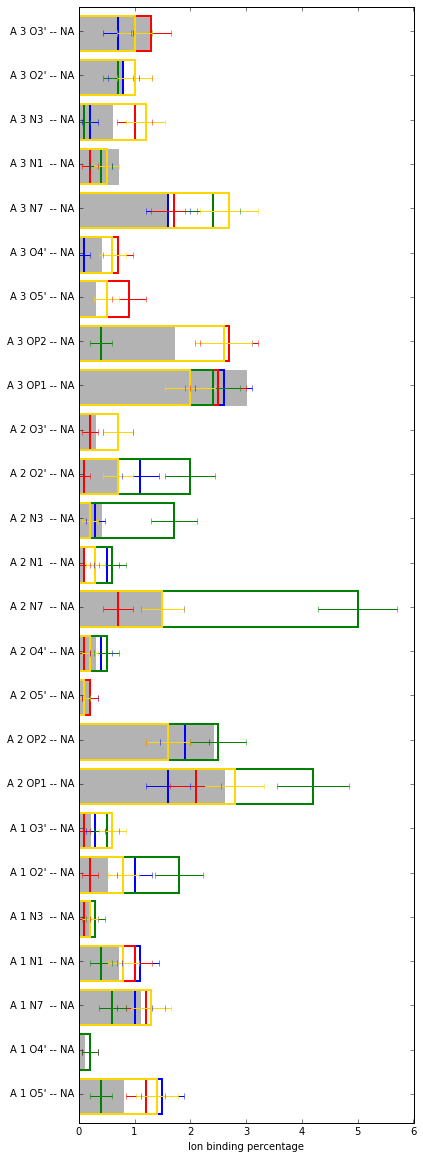

In [133]:
plt.figure(figsize=(6,20))
plt.barh(range(25),ib_perc[0,:25],color='0.7',edgecolor='0.7')
for istate in range(nstates):
    plt.barh(range(25),ib_perc[istate+1,:25],xerr=ib_err[istate+1,:25],\
             ecolor=colors[istate],color='',edgecolor=colors[istate],lw=2)
plt.ylim(-0.2,25)
cacca=plt.yticks(np.arange(0.45,25,1.),ib_names[:25])
plt.xlabel('Ion binding percentage')

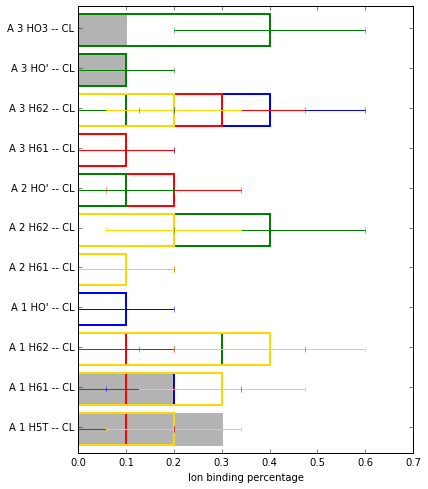

In [134]:
plt.figure(figsize=(6,8))
plt.barh(range(25,36),ib_perc[0,25:36],color='0.7',edgecolor='0.7')
for istate in range(nstates):
    plt.barh(range(25,36),ib_perc[istate+1,25:36],xerr=ib_err[istate+1,25:36],\
             ecolor=colors[istate],color='',edgecolor=colors[istate],lw=2)
plt.ylim(25-0.2,36)
cacca=plt.yticks(np.arange(25.45,36,1.),ib_names[25:36])
plt.xlabel('Ion binding percentage')

## 3.3 - Stacking

Using the stacking score defined by Condon et al., JCTC (2015)

In [135]:
import stackdef as stack
feat_stack=coor.featurizer(topfile)
for i in range(3):
    for j in range(i+1,3):
        print 'stacking between:',i,j
        feat_stack.add_custom_func(stack.get_stack_score,1,i,j)
print 'N. of features:',feat_stack.dimension()

stacking between: 0 1
stacking between: 0 2
stacking between: 1 2
N. of features: 3


In [136]:
### cmomputing observables
stack_meta_states=np.array(coor.load(outfiles,feat_stack,chunk_size=500))

getting output of FeatureReader: 100% (8/8) [######################] eta 00:00 -

In [137]:
stack_percentages=[]
for istate in range(nstates):
    tmp_stack=[]
    for kres in range(3):
        print len(np.where(stack_meta_states[istate][:,kres]>0.1)[0])/10.,
        tmp_stack.append(len(np.where(stack_meta_states[istate][:,kres]>0.1)[0])/10.)
    stack_percentages.append(np.array(tmp_stack))
    print ''
stack_percentages=np.array(stack_percentages)

18.5 28.3 20.6 
32.5 14.0 47.3 
0.0 97.8 52.8 
58.8 1.3 56.4 


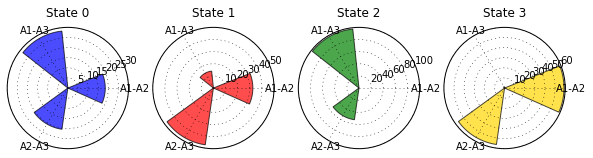

In [138]:
f,axs = plt.subplots(1,4,subplot_kw=dict(projection='polar'),figsize=(10,4))
f.subplots_adjust(wspace=0.2)
for istate in range(nstates):
    ax=axs[istate]
    ax.bar([(x-0.2)*np.pi/3*2 for x in range(3)],stack_percentages[istate],\
           label='state '+str(istate),color=colors[istate],alpha=0.7)
    temp=ax.set_xticks([x*2*np.pi/3 for x in range(3)])
    labs=[]
    for ires in range(3):
        for jres in range(ires+1,3):
            labs.append('A%s-A%s' % (ires+1,jres+1))
    temp=ax.set_xticklabels(labs)#,rotation=60)
    ax.set_title('State '+str(istate),fontsize=12)

## 3.5 G-vectors

In [139]:
var_names=[]
### G-VECTORS
nres=3
for ires in range(nres):
    for jres in range(nres):
        for mu in ['x','y','z','t']:
            var_names.append('$(G_{'+str(ires+1)+' '+str(jres+1)+'})_'+mu+'$')            
### BACKBONE DIHEDRALS
for lll,name in zip(lista_dihedrals,[r'\alpha',r'\beta',r'\gamma',r'\delta',r'\epsilon',r'\zeta']):
    for i in range(len(lll)):
        if name=='\alpha' or name=='\beta':
            var_names.append(r'$\cos('+name+'_'+str(i+2)+')$')
            var_names.append(r'$\sin('+name+'_'+str(i+2)+')$')
        else:
            var_names.append(r'$\cos('+name+'_'+str(i+1)+')$')
            var_names.append(r'$\sin('+name+'_'+str(i+1)+')$')
### PUCKERING ANGLES
for lll,name in zip(lista_pucker,[r'\nu^0',r'\nu^1',r'\nu^2',r'\nu^3',r'\nu^4']):
    for i in range(len(lll)):
        var_names.append(r'$\cos('+name+'_'+str(i+1)+')$')
        var_names.append(r'$\sin('+name+'_'+str(i+1)+')$')
lll=lista_chis
name=r'\chi'
### CHI ANGLES
for i in range(len(lll)):
    var_names.append(r'$\cos('+name+'_'+str(i+1)+')$')
    var_names.append(r'$\sin('+name+'_'+str(i+1)+')$')

In [140]:
feat_G=coor.featurizer(topfile)
nres=3
feat_G.add_custom_func(gv.get_gvecs,4*nres*nres)
inp_G = coor.source(trajfiles, feat_G)

Obtaining file info: 100% (17/17) [################################] eta 00:00 \

In [141]:
### cmomputing observables
gvec_meta_states=np.array(coor.load(outfiles,feat_G))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:00 \

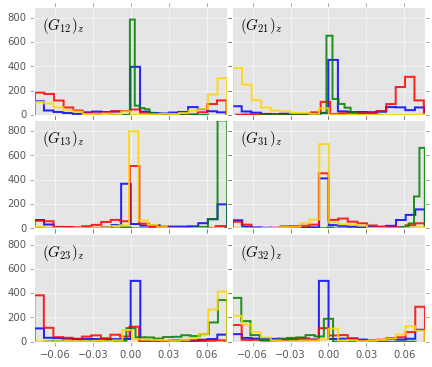

In [142]:
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(3,2, \
        figsize=(7,6),sharex=True,sharey=True)#,sharey=True,sharex=True)
    plt.subplots_adjust(hspace=0.05,wspace=0.025)
    kplt=0
    for kgkg in [[6,14],[10,26],[22,30]]:
        for k_gvec,iplt in zip(kgkg,[0,1]):
            ax=axes[kplt,iplt]
            for istate in range(nstates):            
                ax.hist(gvec_meta_states[istate][:,k_gvec],
                        bins=20,color=colors[istate],histtype='step',lw=2,\
                    label=str(istate),alpha=0.85)
            ax.text(-0.07,700,var_names[k_gvec],fontsize=15)
        kplt+=1
        ax.set_yticks(range(0,900,200))
        ax.set_xticks(np.arange(-0.06,0.07,0.03))

# 4 - Flux analysis

Analysis of the flux by means of transition path theory

In [143]:
flusso23=msm.tpt(M,HMM4.metastable_sets[2],HMM4.metastable_sets[3])
flusso32=msm.tpt(M,HMM4.metastable_sets[3],HMM4.metastable_sets[2])
CGsets32,CGflux32=flusso32.coarse_grain(HMM4.metastable_sets)
CGsets23,CGflux23=flusso23.coarse_grain(HMM4.metastable_sets)
CGpaths23,CGcaps23=CGflux23.pathways(fraction=0.95)
CGpaths32,CGcaps32=CGflux32.pathways(fraction=0.95)

In [144]:
for  ccc in CGsets23:
    print len(ccc)
print
for  ccc in HMM4.metastable_sets:
    print len(ccc)
print
for  ccc in CGsets32:
    print len(ccc)
print

7
41
22
30

41
22
7
30

30
41
22
7



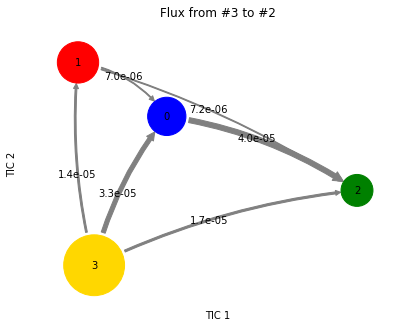

In [145]:
mpl.plot_flux(CGflux32,pos=states_pos[[3,0,1,2]],max_width=7,arrow_label_format='%2.1e',\
              state_labels=['3','0','1','2'],state_colors=colors[[3,0,1,2]])
plt.title('Flux from #3 to #2')
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')
ttt=plt.xticks([])

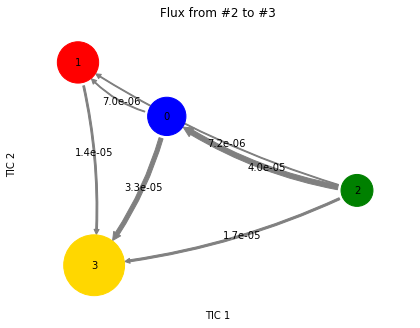

In [146]:
mpl.plot_flux(CGflux23,pos=states_pos[[2,0,1,3]],max_width=7,arrow_label_format='%2.1e',\
              state_labels=['2','0','1','3'],state_colors=colors[[2,0,1,3]])
plt.title('Flux from #2 to #3')
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')
ttt=plt.xticks([])

Observation on the Transition Path Theory results:
1. The transition 3->2 goes through state #0 ~75% of the time (and viceversa)
2. ...

# Kinetics of stacking

In [147]:
inp_stack=coor.source(trajfiles,feat_stack,chunk_size=500)
%time traj_stack=coor.load(trajfiles,feat_stack,chunk_size=500)
avg_stack_cl=my.average_by_state(M,inp_stack,traj=traj_stack)

getting output of FeatureReader: 100% (1153/1153) [################] eta 00:01 -CPU times: user 23min 12s, sys: 2.01 s, total: 23min 14s
Wall time: 23min 13s


In [148]:
std_stack_cl=my.std_by_state(M,inp_stack,traj=traj_stack)

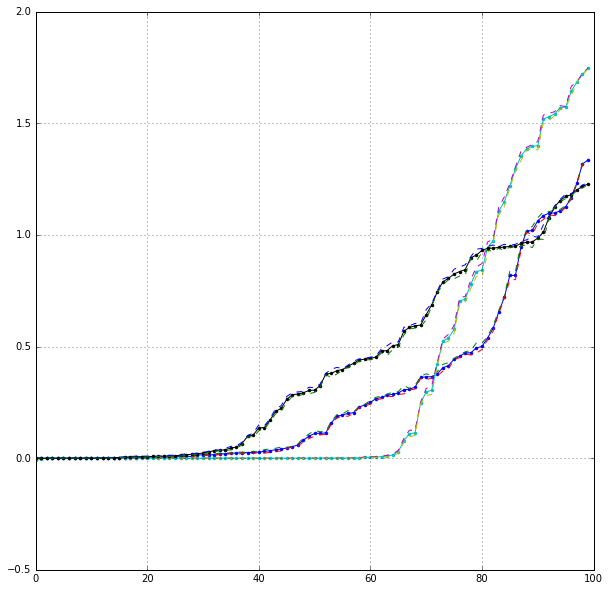

In [149]:
plt.figure(figsize=(10,10))
for istack in range(0,3,1):
    order=np.argsort(avg_stack_cl[:,istack])
    plt.plot(avg_stack_cl[order,istack],marker='.')
    plt.plot(avg_stack_cl[order,istack]+std_stack_cl[order,istack],ls='--')
    plt.plot(avg_stack_cl[order,istack]-std_stack_cl[order,istack],ls='--')
plt.grid()

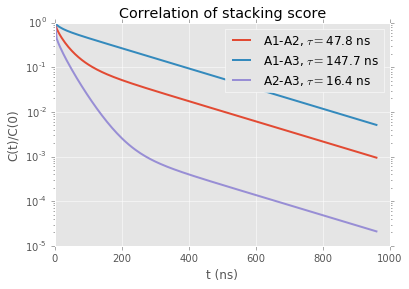

In [150]:
with plt.style.context(('ggplot')):
    kres=0
    for ires in range(3):
        for jres in range(ires+1,3):
            media_sq=np.dot(avg_stack_cl[:,kres],M.stationary_distribution)**2
            times,corr=M.correlation(avg_stack_cl[:,kres])
            acorr=(corr-media_sq)/(corr[0]-media_sq)
            t_corr=(0.5+np.sum(acorr[1:]))*M.lag/10
            plt.plot(times/10,acorr,lw=2,\
                     label=r'A%d-A%d, $\tau=$%.1f ns'%(ires+1,jres+1,t_corr))
            kres+=1
    plt.ylabel('C(t)/C(0)');plt.xlabel('t (ns)')
    plt.yscale('log')
    plt.legend()
    plt.title('Correlation of stacking score')

In [151]:
#plt.plot(M.eigenvectors_left()[0,:],M.stationary_distribution,ls='',marker='.')
print M.eigenvectors_left()[1:,:].shape
print avg_stack_cl.shape
temp=np.tensordot(M.eigenvectors_left()[1:,:],avg_stack_cl,axes=[1,0])
print temp.shape
tau_a=np.sum( (temp**2)*M.timescales()[:,np.newaxis] ,axis=0)\
/np.sum(temp**2,axis=0)
print tau_a/10.

(99, 100)
(100, 3)
(99, 3)
[  47.7591212   148.60605987   15.70459056]


Since the first eigenvector does not correspong to physical structures we can remove it from the analysis

In [152]:
#evec_idx=np.arange(1,M.nstates)
evec_idx=np.arange(2,100)
roba=np.tensordot(M.eigenvectors_left()[evec_idx,:],avg_stack_cl,axes=[1,0])
tau_a=np.sum( (roba**2)*M.timescales()[evec_idx-1,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print '\nStacking autocorrelation times:\n'
print 'A1-A2 = %2.1f ns' % (tau_a[0]/10.)
print 'A1-A3 = %2.1f ns' % (tau_a[1]/10.)
print 'A2-A3 = %2.1f ns' % (tau_a[2]/10.)


Stacking autocorrelation times:

A1-A2 = 24.5 ns
A1-A3 = 17.1 ns
A2-A3 = 15.2 ns


In [153]:
taus=[]
for M in BM.samples:
    roba=np.tensordot(M.eigenvectors_left()[evec_idx,:],avg_stack_cl,axes=[1,0])
    tau_a=np.sum( (roba**2)*M.timescales()[evec_idx-1,np.newaxis] ,axis=0)\
        /np.sum(roba**2,axis=0)
    taus.append(tau_a)
taus=np.array(taus)
print taus.shape

(100, 3)


In [154]:
m=np.mean(taus,axis=0)
s=np.std(taus,axis=0)

In [155]:
print '\nStacking autocorrelation times:\n'
print 'A1-A2 = %2.1f +- %1.2f ns' % (m[0]/10.,s[0]/10.)
print 'A1-A3 = %2.1f +- %1.2f ns' % (m[1]/10.,s[1]/10.)
print 'A2-A3 = %2.1f +- %1.2f ns' % (m[2]/10.,s[2]/10.)


Stacking autocorrelation times:

A1-A2 = 24.4 +- 0.61 ns
A1-A3 = 17.4 +- 0.95 ns
A2-A3 = 15.0 +- 0.47 ns


# Reduced MSM

I construct a reduced MSM by removing the states where the 1st eigenvector has a negative value (Corresponding to intercalated structures!).

**Warning:** the sign of the eigenvector is undefined so it may change from one machine to the other. Check this if you are executing this notebook on you machine

In [156]:
import msmtools

(88, 88) 88 12
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
True
True


Reduced MSM timescales:
  46 ns
  42 ns
  36 ns
  28 ns
  25 ns
  22 ns


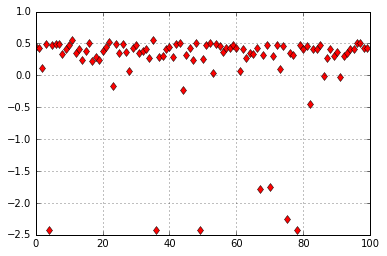

In [157]:
T=M.transition_matrix
r1=M.eigenvectors_right()[:,1]
plt.plot(r1,'rd')
plt.grid()
idx=np.where(r1>0)[0]
ex_idx=np.where(r1<=0)[0]
T_rem=T[np.ix_(idx,idx)].copy()
print T_rem.shape,len(idx),len(ex_idx)
for i in range(len(idx)):
    T_rem[i,i]+=np.sum(T[idx[i],ex_idx])
print np.sum(T_rem,axis=1)
print msmtools.analysis.is_transition_matrix(T_rem)
print msmtools.analysis.is_reversible(T_rem)
print '\n\nReduced MSM timescales:'
for i in range(1,7):
    print '  %2.f ns'%(msmtools.analysis.timescales(T_rem,50,reversible=True)[i]/10)

I can compare the timescales of the original MSM with the reduced one:

In [158]:
print 'MSM timescales:'
print 'Original | Reduced'
for i in range(7):
    print('%3.f ns   | %3.f ns' % (M.timescales()[i]/10,\
                                 msmtools.analysis.timescales(T_rem,50,reversible=True)[i]/10) )

MSM timescales:
Original | Reduced
202 ns   | inf ns
 41 ns   |  46 ns
 40 ns   |  42 ns
 30 ns   |  36 ns
 27 ns   |  28 ns
 23 ns   |  25 ns
 21 ns   |  22 ns


The first process has been removed in the reduced MSM, and the other timescales are close to the original ones (within statistical uncertainty)

## Kinetics of stacking

This can be checked also for the stacking autocorrelation time

In [159]:
#ORIGINAL MSM
evec_idx=np.arange(2,100)
roba=np.tensordot(M.eigenvectors_left()[evec_idx,:],avg_stack_cl,axes=[1,0])
tau_a=np.sum( (roba**2)*M.timescales()[evec_idx-1,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print '\nStacking autocorrelation times:\n'
print 'A1-A2 = %2.1f ns' % (tau_a[0]/10.)
print 'A1-A3 = %2.1f ns' % (tau_a[1]/10.)
print 'A2-A3 = %2.1f ns' % (tau_a[2]/10.)


Stacking autocorrelation times:

A1-A2 = 23.3 ns
A1-A3 = 16.5 ns
A2-A3 = 14.9 ns


In [160]:
#REDUCED MSM
evec_idx=np.arange(1,T_rem.shape[0])

roba=np.tensordot(msmtools.analysis.eigenvectors(T_rem,right=False,reversible=True)[evec_idx,:],\
                  avg_stack_cl[idx],axes=[1,0])
print roba.shape
tau_a=np.sum( (roba**2)*msmtools.analysis.timescales(T_rem,50)[evec_idx,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print '\nStacking autocorrelation times:\n'
print 'A1-A2 = %2.1f ns' % (tau_a[0]/10.)
print 'A1-A3 = %2.1f ns' % (tau_a[1]/10.)
print 'A2-A3 = %2.1f ns' % (tau_a[2]/10.)

(87, 3)

Stacking autocorrelation times:

A1-A2 = 22.2 ns
A1-A3 = 17.1 ns
A2-A3 = 16.8 ns


The autocorrelation times of the stacking scores of the reduced model are in agreement with the autocorrelation times computed from the original model excluding the 1st process from the calculation